ДЗ: Используя torch решить на выбор одну домашнюю работу. Например MFO. Дедлайн 04.09


https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ ДЗ - оценить возраст человека по изображению. В качестве датасета возьмите датасет только лиц. Предположим что сами лица вы находить и извлекать уже умеете. Можете сделать это как продолжение решения по поиску лиц из предыдущих работ. https://www.google.com/amp/s/www.geeksforgeeks.org/age-detection-using-deep-learning-in-opencv/amp/ пример того как это может работать.
В качестве фьючеэкстрактора берите любую современную нейронную сеть. Задачу можно решать как задачу регрессии или классификации.
Если есть время можете попробовать 2 способа. Попробуйте разблокировать часть слоев после обучения и дообучить модель.

Указание - что бы решить задачу регресси вам нужно использовать flow_from_dataframe Указание - для начала вам нужно создать датафрейм в котором будет относительный путь к изображению и целевая метка, потом использовать этот датафрейм при обучении

In [20]:
import os
import sys
import wget
import shutil
import tarfile


import re
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt




import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

from torch.utils.data import Dataset, DataLoader, random_split


import warnings
warnings.filterwarnings('ignore')



print('OpenCV version ' + cv2.__version__)

OpenCV version 4.8.0


In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
# Гиперпараметры
EPOCHS = 300
BATCH = 64
TARGET_SIZE = (64,64)
LR = 1e-3  # Скорость обучения
EARLY_STOPPING_EPOCHS = 5 # Количество эпох без улучшения

In [ ]:
#Извлекаем файлы из архивва


# Путь к вашему архиву imdb_crop.tar
archive_path = 'C:/Users/SergS/Study/DS04/DS04_2/HW_43/imdb_crop.tar'
# Путь, куда вы хотите извлечь файлы
output_path = 'C:/Users/SergS/Study/DS04/DS04_2/HW_43/'

# Открываем архив для чтения
with tarfile.open(archive_path, 'r') as tar:
    # Извлекаем все файлы в указанную папку
    tar.extractall(output_path)

In [4]:
DATA_FOLDER = 'imdb_crop'

Выполним загрузку, проверку и обработку набора изображений из файлов

In [ ]:
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение и сконвертировать в монохромное
                img = Image.open(source_file_path).convert('L')
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 128:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    
                    img_bad_faces+=1
                    continue  

               
                
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                    
                except:
                    label = -1 
                    
                
                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects1[0]
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.Resampling.BILINEAR)    

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                #cropped_images = cropped_images.append({'file_path': cropped_file_path, 'label': label}, ignore_index=True)
                cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': cropped_file_path, 'label': label}])], ignore_index=True)
                img.save(cropped_file_path)
                
                
            except Exception as ex:
                #print(ex)
                img_misloaded+=1
                print(ex)
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops.csv')

Отобразим произвольные 40 файлов изображений из набора обработанных данных

<Axes: >

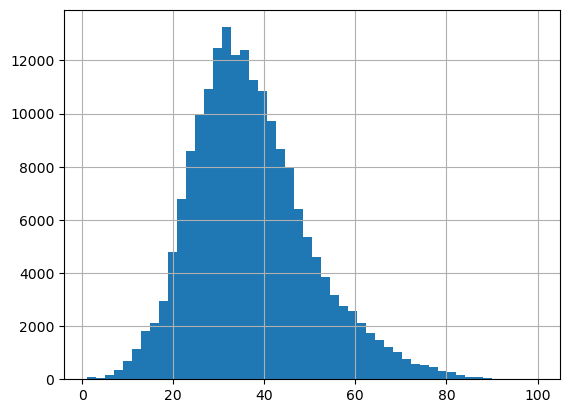

In [14]:
cropped_images['label'].hist(bins=50)

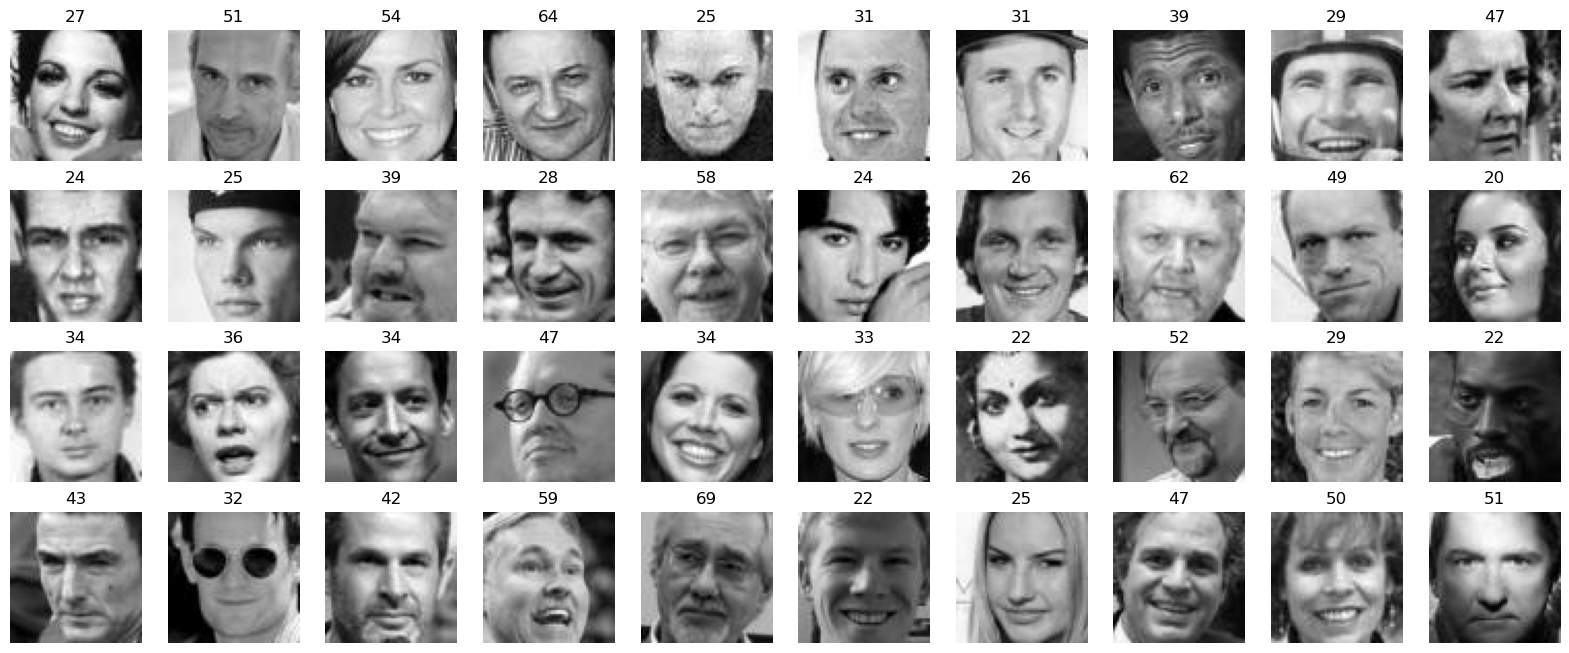

In [99]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

In [6]:
df = pd.read_csv("imdb_crops.csv")
df.head(3)

,Unnamed: 0,file_path,label
0,0,imdb_crop\cropped\nm0000100_rm1002674432_1955-...,48
1,1,imdb_crop\cropped\nm0000100_rm1018346496_1955-...,56
2,2,imdb_crop\cropped\nm0000100_rm1096259584_1955-...,52


проверка что каждому пути соответствует фотография, в случае если фотографии нет, удаляем строку

In [7]:


# Загрузка вашего DataFrame


# Функция для проверки наличия файла по пути
def file_exists(file_path):
    return os.path.exists(file_path)

# Применение функции к столбцу "file_path" и создание нового столбца "file_exists"
df['file_exists'] = df['file_path'].apply(file_exists)

# Удаление строк, в которых файлы не существуют
df = df[df['file_exists']]

# Удаление столбца "file_exists", если он больше не нужен
df = df.drop(columns=['file_exists'])

# Теперь DataFrame не содержит строк с недоступными файлами


In [8]:
df.head(3)

,Unnamed: 0,file_path,label
0,0,imdb_crop\cropped\nm0000100_rm1002674432_1955-...,48
1,1,imdb_crop\cropped\nm0000100_rm1018346496_1955-...,56
2,2,imdb_crop\cropped\nm0000100_rm1096259584_1955-...,52


---

In [17]:
df['label'] = df['label'].astype(np.int32)

In [4]:
# Определение места, где будут производиться расчёта. Если есть видеокарта, значит на видеокарте
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    

In [18]:


# Предобработка данных
transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),
])

# Создание класса Dataset для загрузки данных
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(float(self.data.iloc[idx, 2]))  # Предполагается, что возраст хранится в столбце 'label'
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# # Создание DataLoader
# # df["file_path"] = df["file_path"].str.replace('\\', '/')
# # df['file_path'] = df['file_path'].astype(str)
# dataset = CustomDataset(df, transform=transform)
#  # Вы можете выбрать подходящий размер батча
# dataloader = DataLoader(dataset, batch_size=BATCH, shuffle=True)




In [21]:

# Создание экземпляра CustomDataset с вашими данными
# Здесь data - это список с вашими данными
custom_dataset = CustomDataset(df, transform=transform)

# Определение размеров train, test и val выборок
total_samples = len(custom_dataset)
train_size = int(0.7 * total_samples)  # Например, 70% данных для обучения
test_size = int(0.2 * total_samples)   # Например, 20% данных для тестирования
val_size = total_samples - train_size - test_size  # Остальные данные для валидации

# Разделение датасета на выборки
train_dataset, test_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size, val_size])

# Создание DataLoader для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

In [ ]:
# Загрузка предварительно обученной модели MobileNet_V3_Large
weights = models.MobileNet_V3_Large_Weights.DEFAULT
model = models.mobilenet_v3_large(weights=weights)



model.to(device)

In [ ]:
# Загрузка предварительно обученной модели ResNet
model = models.resnet50(pretrained=True)
model.to(device)


In [ ]:
# Заменяем последний слой для регрессии
# num_features = model.fc.in_features
num_features = model.classifier[-1].in_features
regression_layer = nn.Linear(num_features, 1)  # Выходной слой с одним нейроном для регрессии
model.classifier[-1] = regression_layer

In [46]:
# Попытка создать кастомную модель

class CNNNet(nn.Module):

    def __init__(self):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x
    
model = CNNNet()


In [ ]:
model

In [47]:


model.to(device)
# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()  # Среднеквадратичная ошибка (MSE)
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Вы можете настроить скорость обучения (learning rate)

# Инициализация переменных для отслеживания лучшего показателя ошибки
best_loss = float('inf')
best_model = None

In [ ]:
best_loss = 1000
val_loss = 0.0

# Обучение модели
num_epochs = EPOCHS  # Вы можете выбрать количество эпох
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)  # Перемещаем данные на GPU
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels.float())  # Переводим выход модели в одномерный тензор
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    
    
        # Оценка модели на валидационной выборке
    model.eval()
  

    with torch.no_grad():
        for images, labels in test_loader:  # Предполагается, что у вас есть DataLoader для валидационной выборки
            images = images.to(device)  # Перемещаем данные на GPU
            labels = labels.to(device)    
            
            outputs = model(images)
            val_loss += criterion(outputs.view(-1), labels.float()).item()
    val_loss /= len(test_loader)

    # Проверка ранней остановки
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        torch.save(best_model, 'best_model_45_M.pth')  # Сохраняем модель в файл
        early_stopping_epochs = 0  # Сбрасываем счетчик эпох без улучшения
        print("best_loss", best_loss)
    else:
        early_stopping_epochs += 1
        print("val_loss", val_loss)

    # Если достигнут порог без улучшения, останавливаем обучение
    if early_stopping_epochs >= EARLY_STOPPING_EPOCHS:  # Измените на нужное количество эпох без улучшения
        print(f'Early stopping after {epoch+1} epochs without improvement.')
        break


print('Обучение завершено!')
